In [14]:
# tomography notebook for qubit pair: 
q1 = 1
q2 = 3

qt = q1 # control = q1
qc = q2 # tagrget = q2

In [15]:
import os, json
datadir = os.getcwd() + '\\c1_t3_CR_tomography\\'
#os.makedirs(datadir)

# Hamiltonian Tomography

In [16]:
# original : https://qiskit.org/textbook/ch-quantum-hardware/hamiltonian-tomography.html
from qiskit import pulse
import numpy as np
import matplotlib.pyplot as plt
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.test.mock import FakeAthens
IBMQ.load_account()
style = SchedStyle(figsize=(20, 10))
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 15]
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-03-31 14:06:53,882: Credentials are already in use. The existing account in the session will be replaced.


### We will save the Hamiltonian parameters here for building a Duffing oscillator model later.

In [17]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


The `instruction_schedule_map` provides the parameters of the default calibrated pulses used by the backend. In particular, we see that this "native gate set" consists of a subset of operations you can perform on a [`QuantumCircuit`](https://qiskit.org/documentation/apidoc/circuit.html#gates-and-instructions), and is the gate set that the `QuantumCircuit` is transpiled to by Qiskit. 

In [18]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

Here we see the single-qubit ["U-gates"](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#generalU3) `u1`, `u2`, and `u3`, controlled-NOT `cx`, identity `id`, measurement `measure` and $\pi$-pulse `x` for echoes. In particular, this is useful for retrieving pulses from the native gate set and manipulating them. For example, instead of building measurement pulses from scratch, we can retrieve it from the `instruction_schedule_map`.

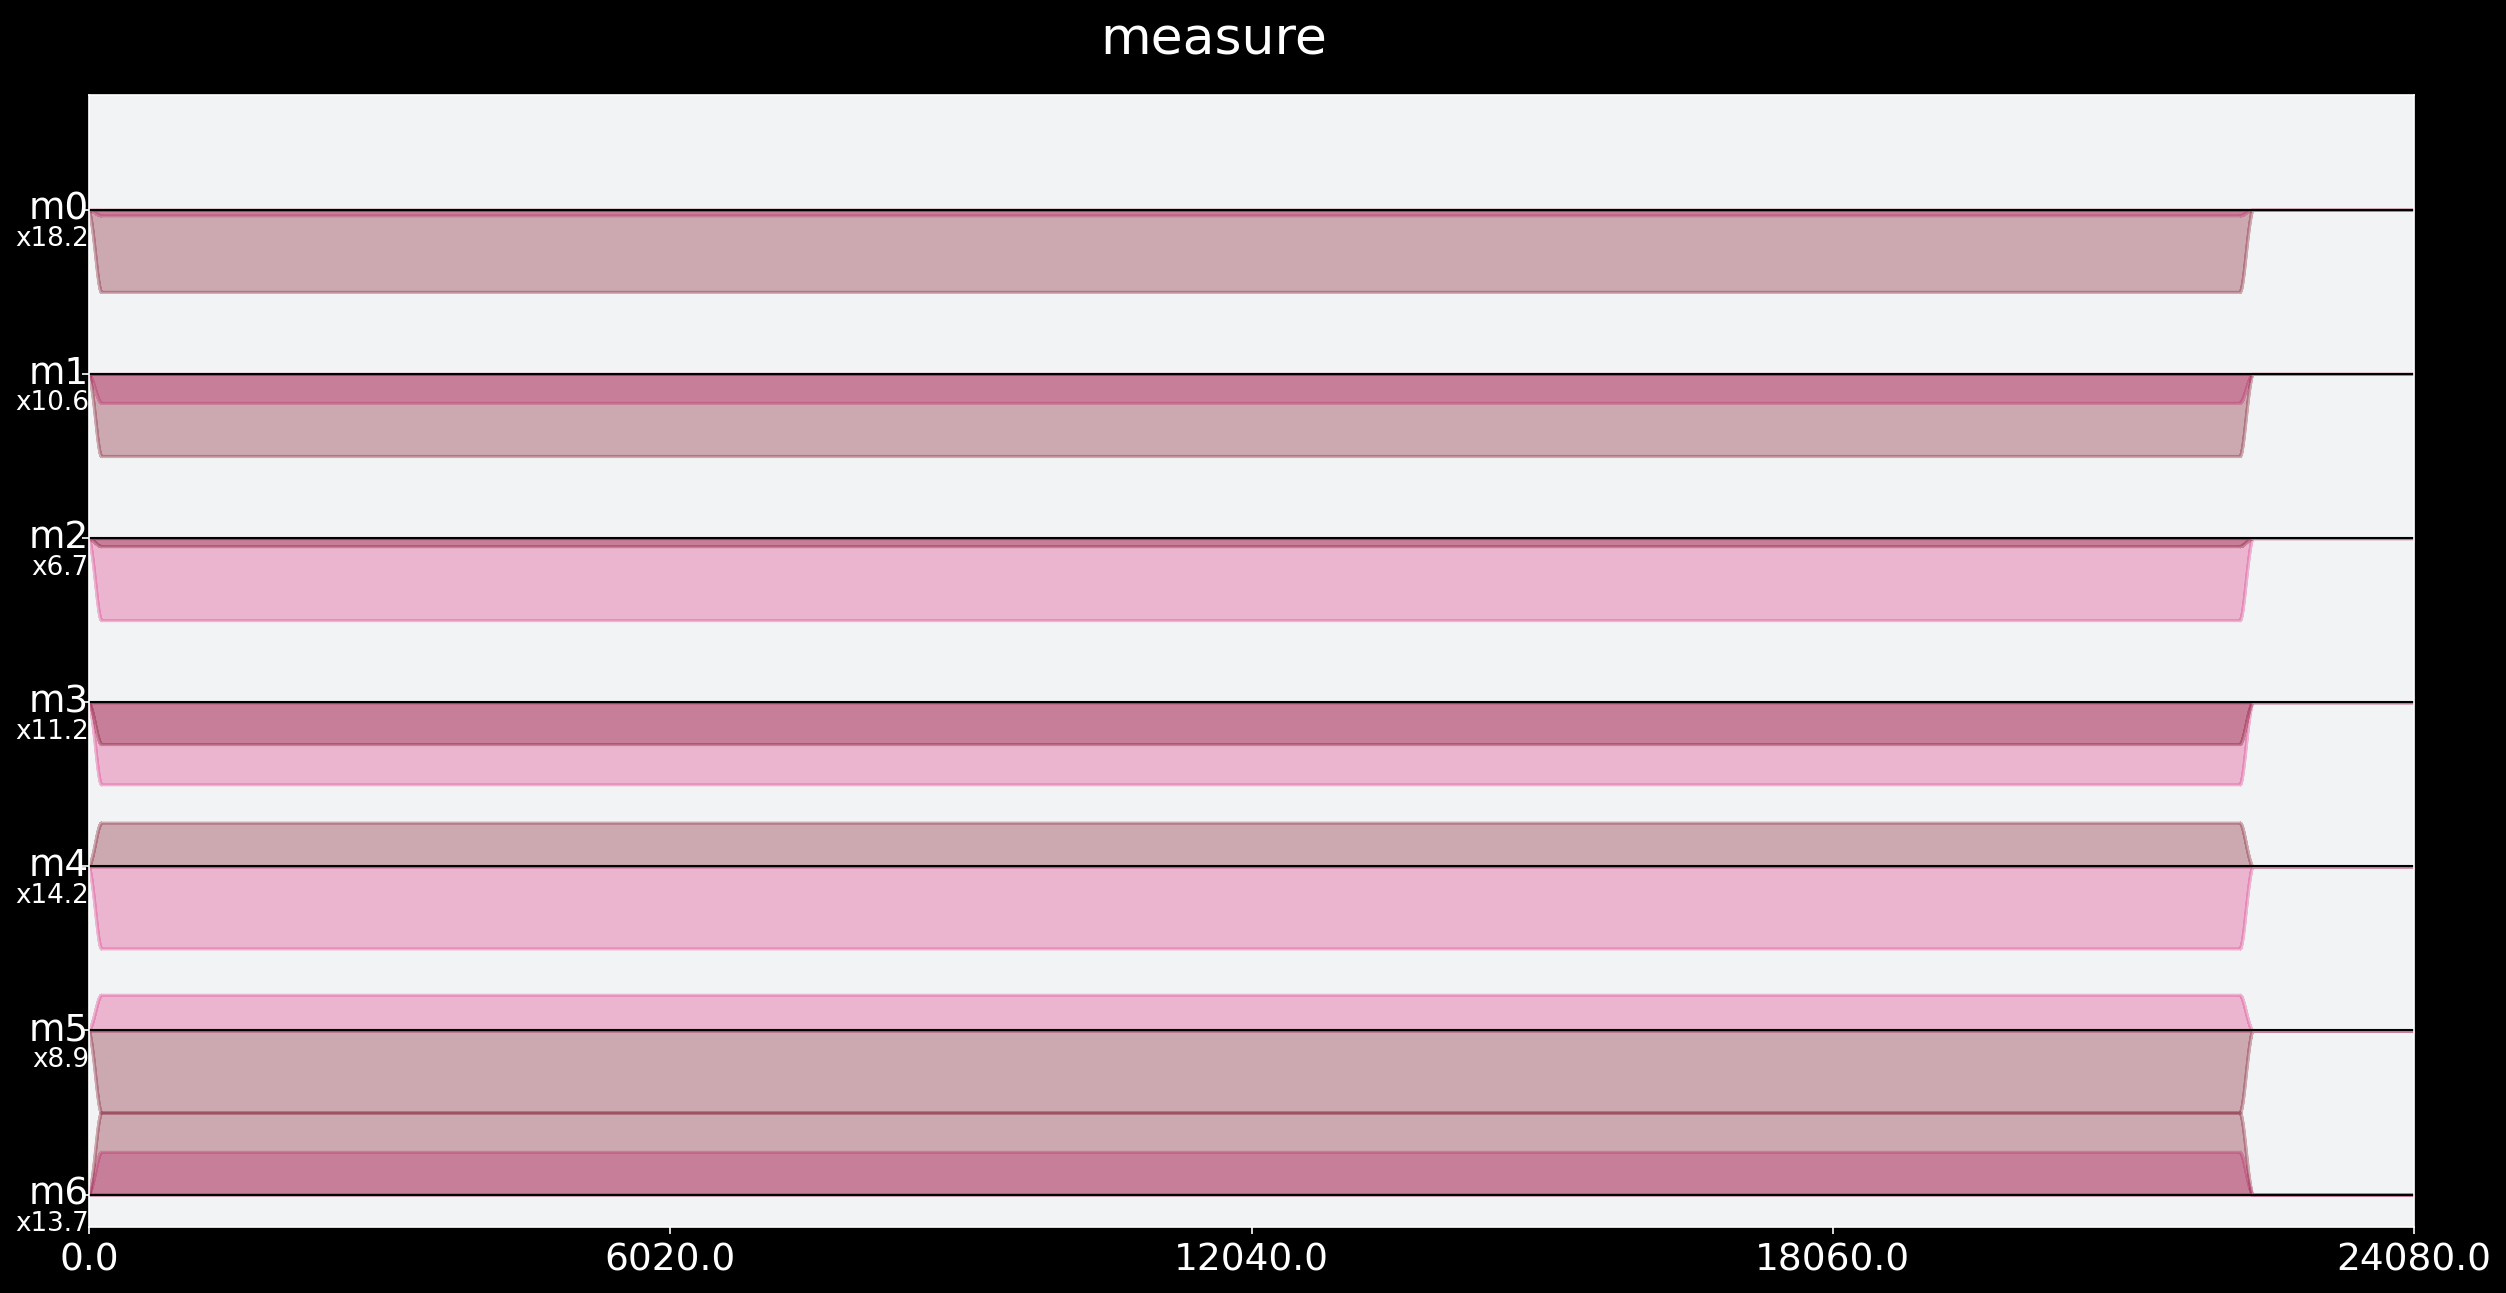

In [19]:
meas = inst_sched_map.get('measure', qubits=range(backend_config.n_qubits))
meas.exclude(channels=[pulse.AcquireChannel(i) 
                        for i in range(backend_config.n_qubits)]).draw(style=style)

For Hamiltonian tomography, we will also need the cross resonance pulse, which we can extract from the controlled-NOT.

In [20]:
def cx_pulse_instructions(qc: int, qt: int) -> Schedule:
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx
    
def get_cr_chan_inst(qc: int, qt: int) -> (ControlChannel, Waveform):
    """Retrieve the cross resonance pulse channel and waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    cx = cx_pulse_instructions(qc, qt)
    idx = 0
    # look for first Play instruction on a ControlChannel
    while (type(cx.instructions[idx][1].channels[0]) is not ControlChannel) or \
        (type(cx.instructions[idx][1]) is not Play):
        idx += 1
    return (cx.instructions[idx][1].channels[0], cx.instructions[idx][1].pulse)

Retrieve the cross resonance waveform and the control channel (`uchan`) it is played on.

In [21]:
uchan, cr_pulse = get_cr_chan_inst(q1, q2)
print("cr_pulse:",cr_pulse,"\nuchan:",uchan)

cr_pulse: GaussianSquare(duration=560, amp=(-0.32609606664029767-0.1591967745569052j), sigma=64, width=304) 
uchan: ControlChannel(5)


Cross resonance pulses are of type [`GaussianSquare`](https://qiskit.org/documentation/stubs/qiskit.pulse.library.GaussianSquare.html), a square pulse with a Gaussian rise and fall. Currently the waveform samples are returned from the `instruction_schedule_map`, so we must elucidate the `GaussianSquare` parameters so we can easily build our own cross resonance pulses. In particular, we wish to find the amplitude because it is typically calibrated to be the largest amplitude that does not result in leakage to the higher order so that the shortest gate length can be achieved.

In [22]:
cr_pulse.parameters

{'duration': 560,
 'amp': (-0.32609606664029767-0.1591967745569052j),
 'sigma': 64,
 'width': 304}

In [23]:
# just for checking code changes are valid:
if cr_pulse.get_sample_pulse() == cr_pulse.get_waveform():
    if cr_pulse.amp == cr_pulse.get_waveform().samples[len(cr_pulse.get_waveform().samples)//2]:
        print("it is fine.")
    else:
        print("need to check amp.")
else:
    print("need to check methods.")
        

it is fine.


C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\pulse\library\parametric_pulses.py:76: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '


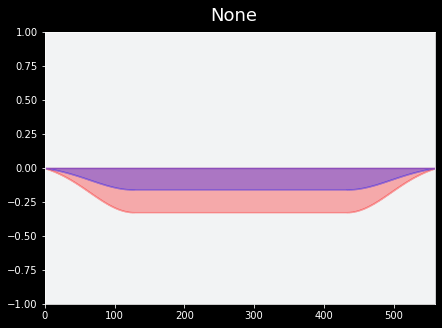

In [24]:
cr_pulse.draw()

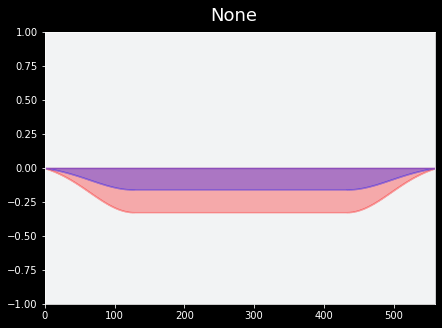

In [25]:
cr_amp = cr_pulse.amp
cr_dur = cr_pulse.duration
cr_risefall = 128 # guess
cr_width = cr_dur - 2*cr_risefall

my_cr_pulse = GaussianSquare(duration=cr_dur, amp=cr_amp, sigma=cr_risefall//2, width=cr_width)
my_cr_pulse.draw()

Let's build a test schedule to visualize the default cross resonance pulse against the one we just constructed.

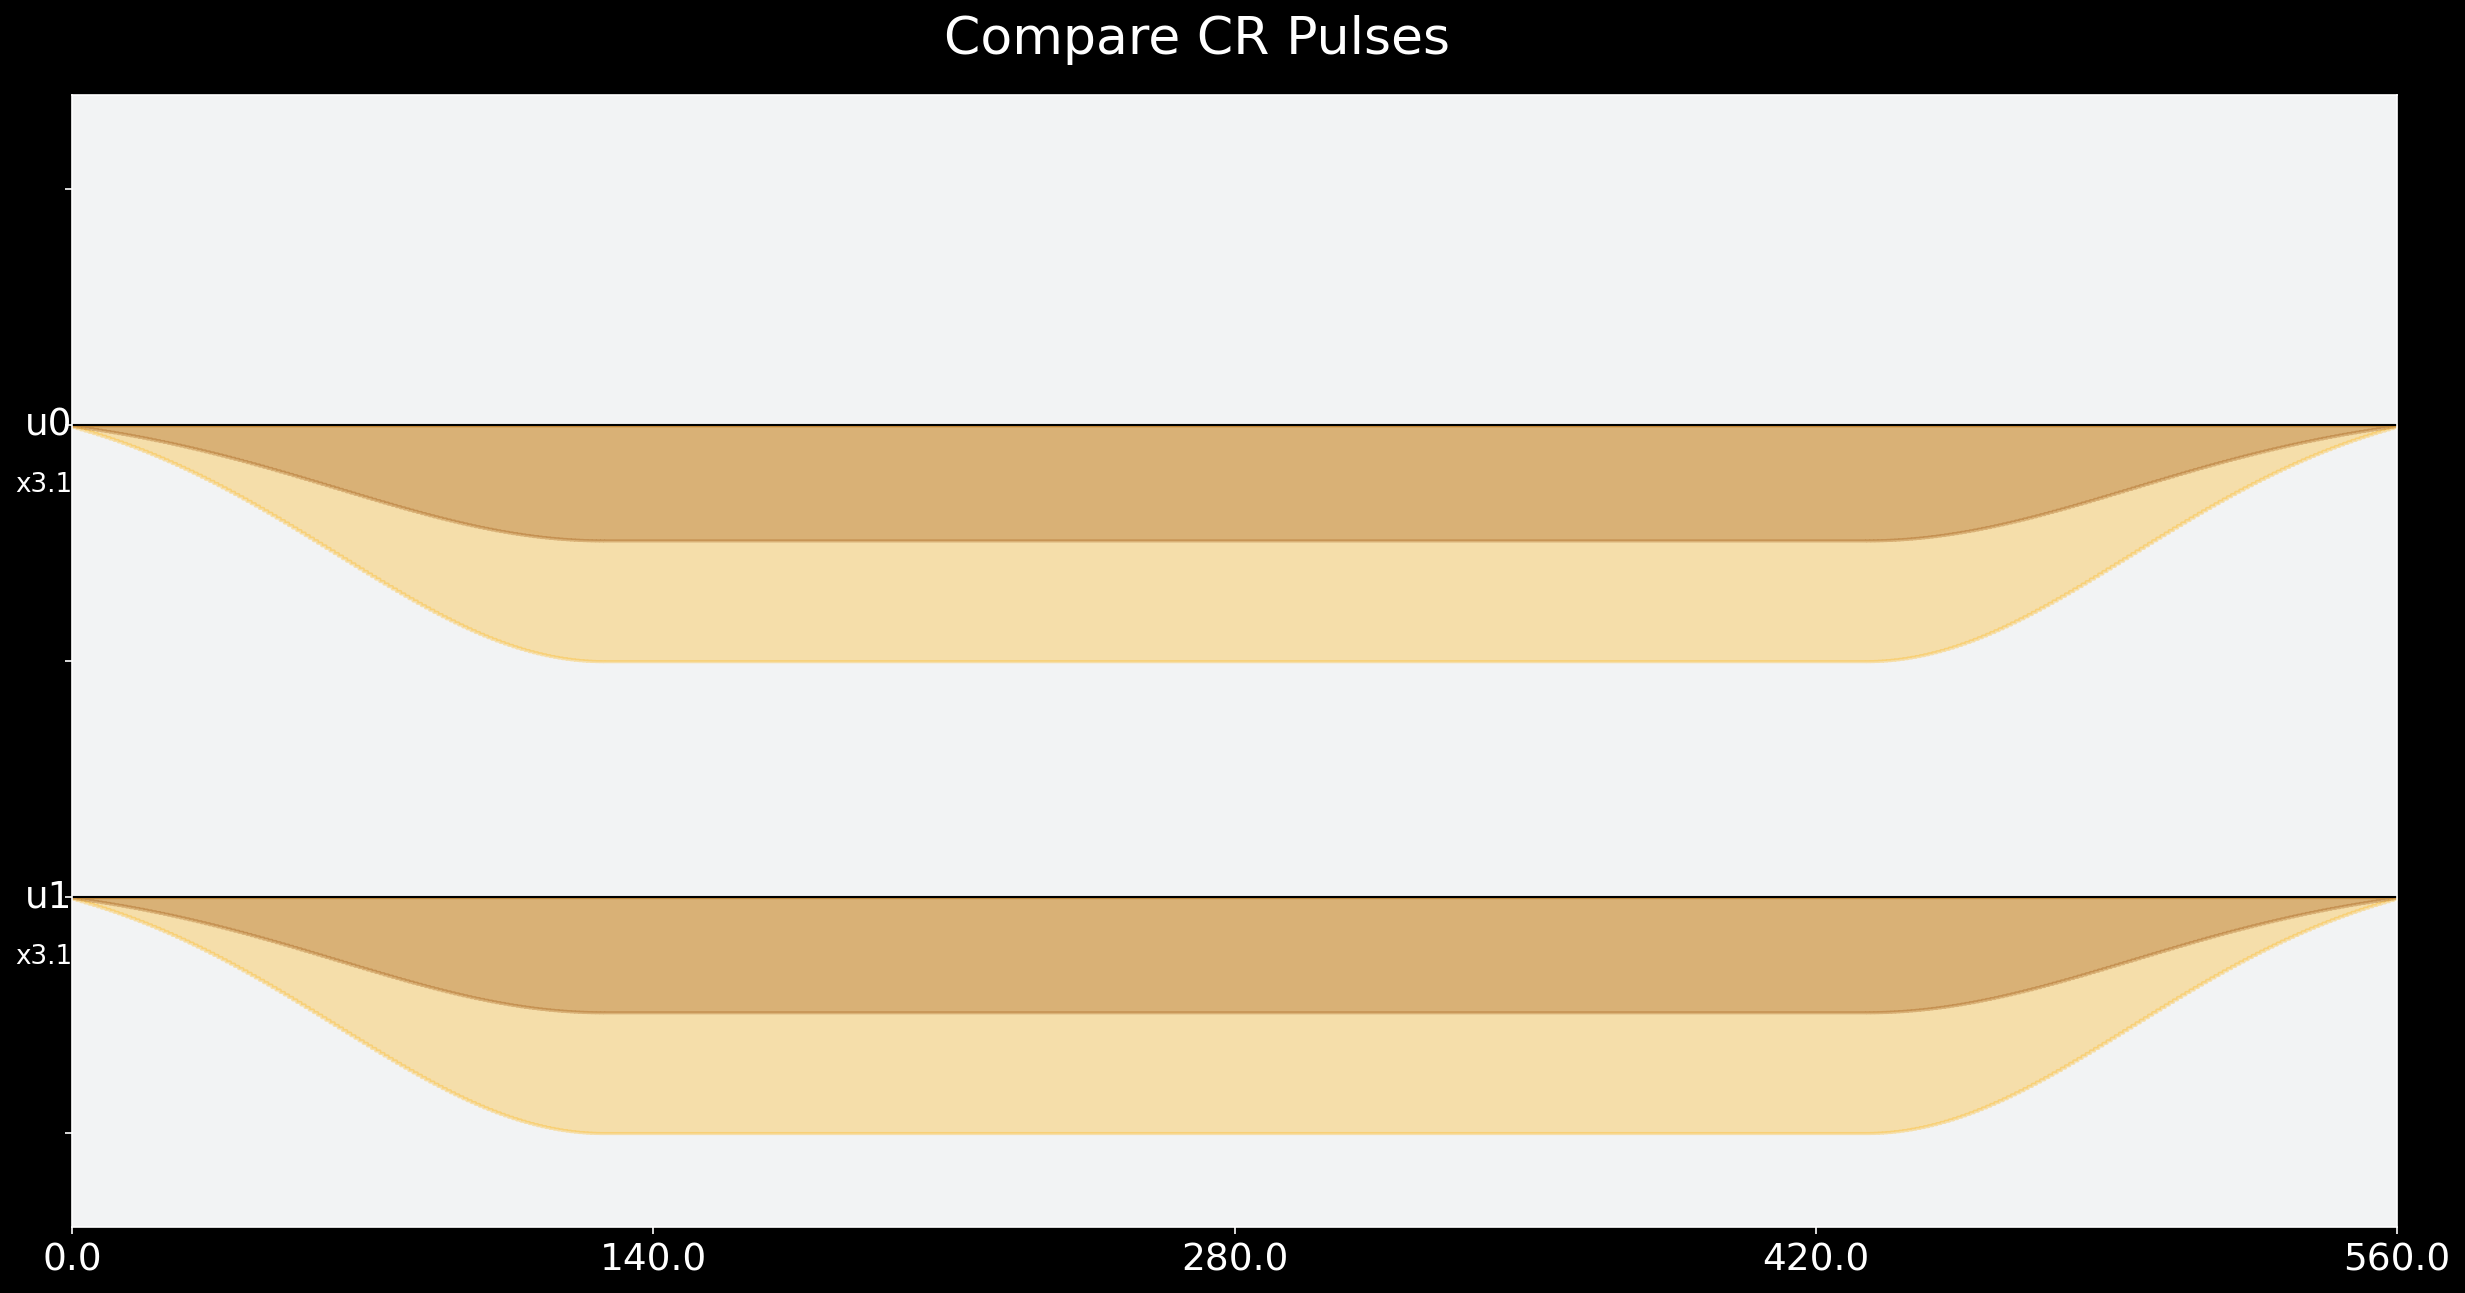

In [26]:
with pulse.build(name="Compare CR Pulses") as cr_test_sched:
    pulse.play(cr_pulse, ControlChannel(0))
    pulse.play(my_cr_pulse, ControlChannel(1))

cr_test_sched.draw(style=style)

Pretty good! This will be close enough for the Hamiltonian tomography experiment. Now, this pulse nominally executes $ZX(\theta=\pi/4)$ corresponding to the [RZXGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html) because the cross resonance pulse is echoed: the first half will be a positive rotation dependent on the state of the control qubit, followed by an "echo pulse" that flips the control qubit, followed by a negative rotation dependent on the new state of the control qubit. This turns out to be equivalent to a $ZX(\theta=\pi/2)$, but we are just dealing with the first part of the pulse so that we can observe the full effect of the cross resonance interaction. We keep this in mind because this particular `cr_dur` will only take us an angle of $\theta=\pi/4$ around the Bloch sphere, and for the Hamiltonian tomography experiment we wish to traverse the Bloch sphere several times.

In [27]:
def build_cr_pulse(qc: int, qt: int, width: int, control='0', 
                   basis='Z', phase=0.0, framechange=0.0) -> Schedule:
    """Build a cross resonance pulse schedule for a given set of parameters.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      width: width of cross resonance pulse (in dt)
      control: control qubit prepared as '0' or '1'
      basis: measurement basis of target qubit
      phase: phase offset of cross resonance pulse (rad)
      framechange: compensated Z-rotation on control performed in software (rad)
    """
    with pulse.build() as sched:
        with pulse.align_sequential():
            if control == '1':
                Xp = inst_sched_map.get('x', qubits=[qc])
                pulse.call(Xp) # flip control from |0> to |1>
            
            duration = width + 2*cr_risefall
            with pulse.phase_offset(phase, uchan):
                pulse.play(GaussianSquare(duration=duration, amp=cr_amp, sigma=cr_risefall//2, width=width), uchan)
            pulse.shift_phase(framechange, DriveChannel(qc))
            
            # rotate target for appropriate Pauli measurement
            if basis == 'X':
                Y90m = inst_sched_map.get('u2', P0=np.pi, P1=np.pi, qubits=[qt])
                pulse.call(Y90m)
            elif basis == 'Y':
                X90p = inst_sched_map.get('u2', P0=-np.pi/2, P1=np.pi/2, qubits=[qt])
                pulse.call(X90p)
            
            return sched

def build_cr_scheds(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0) -> np.array:
    """Build an array of cross resonance schedules for the
    Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_times: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    scheds = []
    for width in cr_times:
        framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
        for basis in ['X', 'Y', 'Z']:
            for control in ['0', '1']:
                with pulse.build(name="CR width %i" %width) as sched:
                    with pulse.align_sequential():
                        pulse.call(build_cr_pulse(qc, qt, int(width), control=control, \
                                                  basis=basis, phase=phase, framechange=framechange))
                        pulse.call(meas)
                scheds.append(sched)
    return scheds

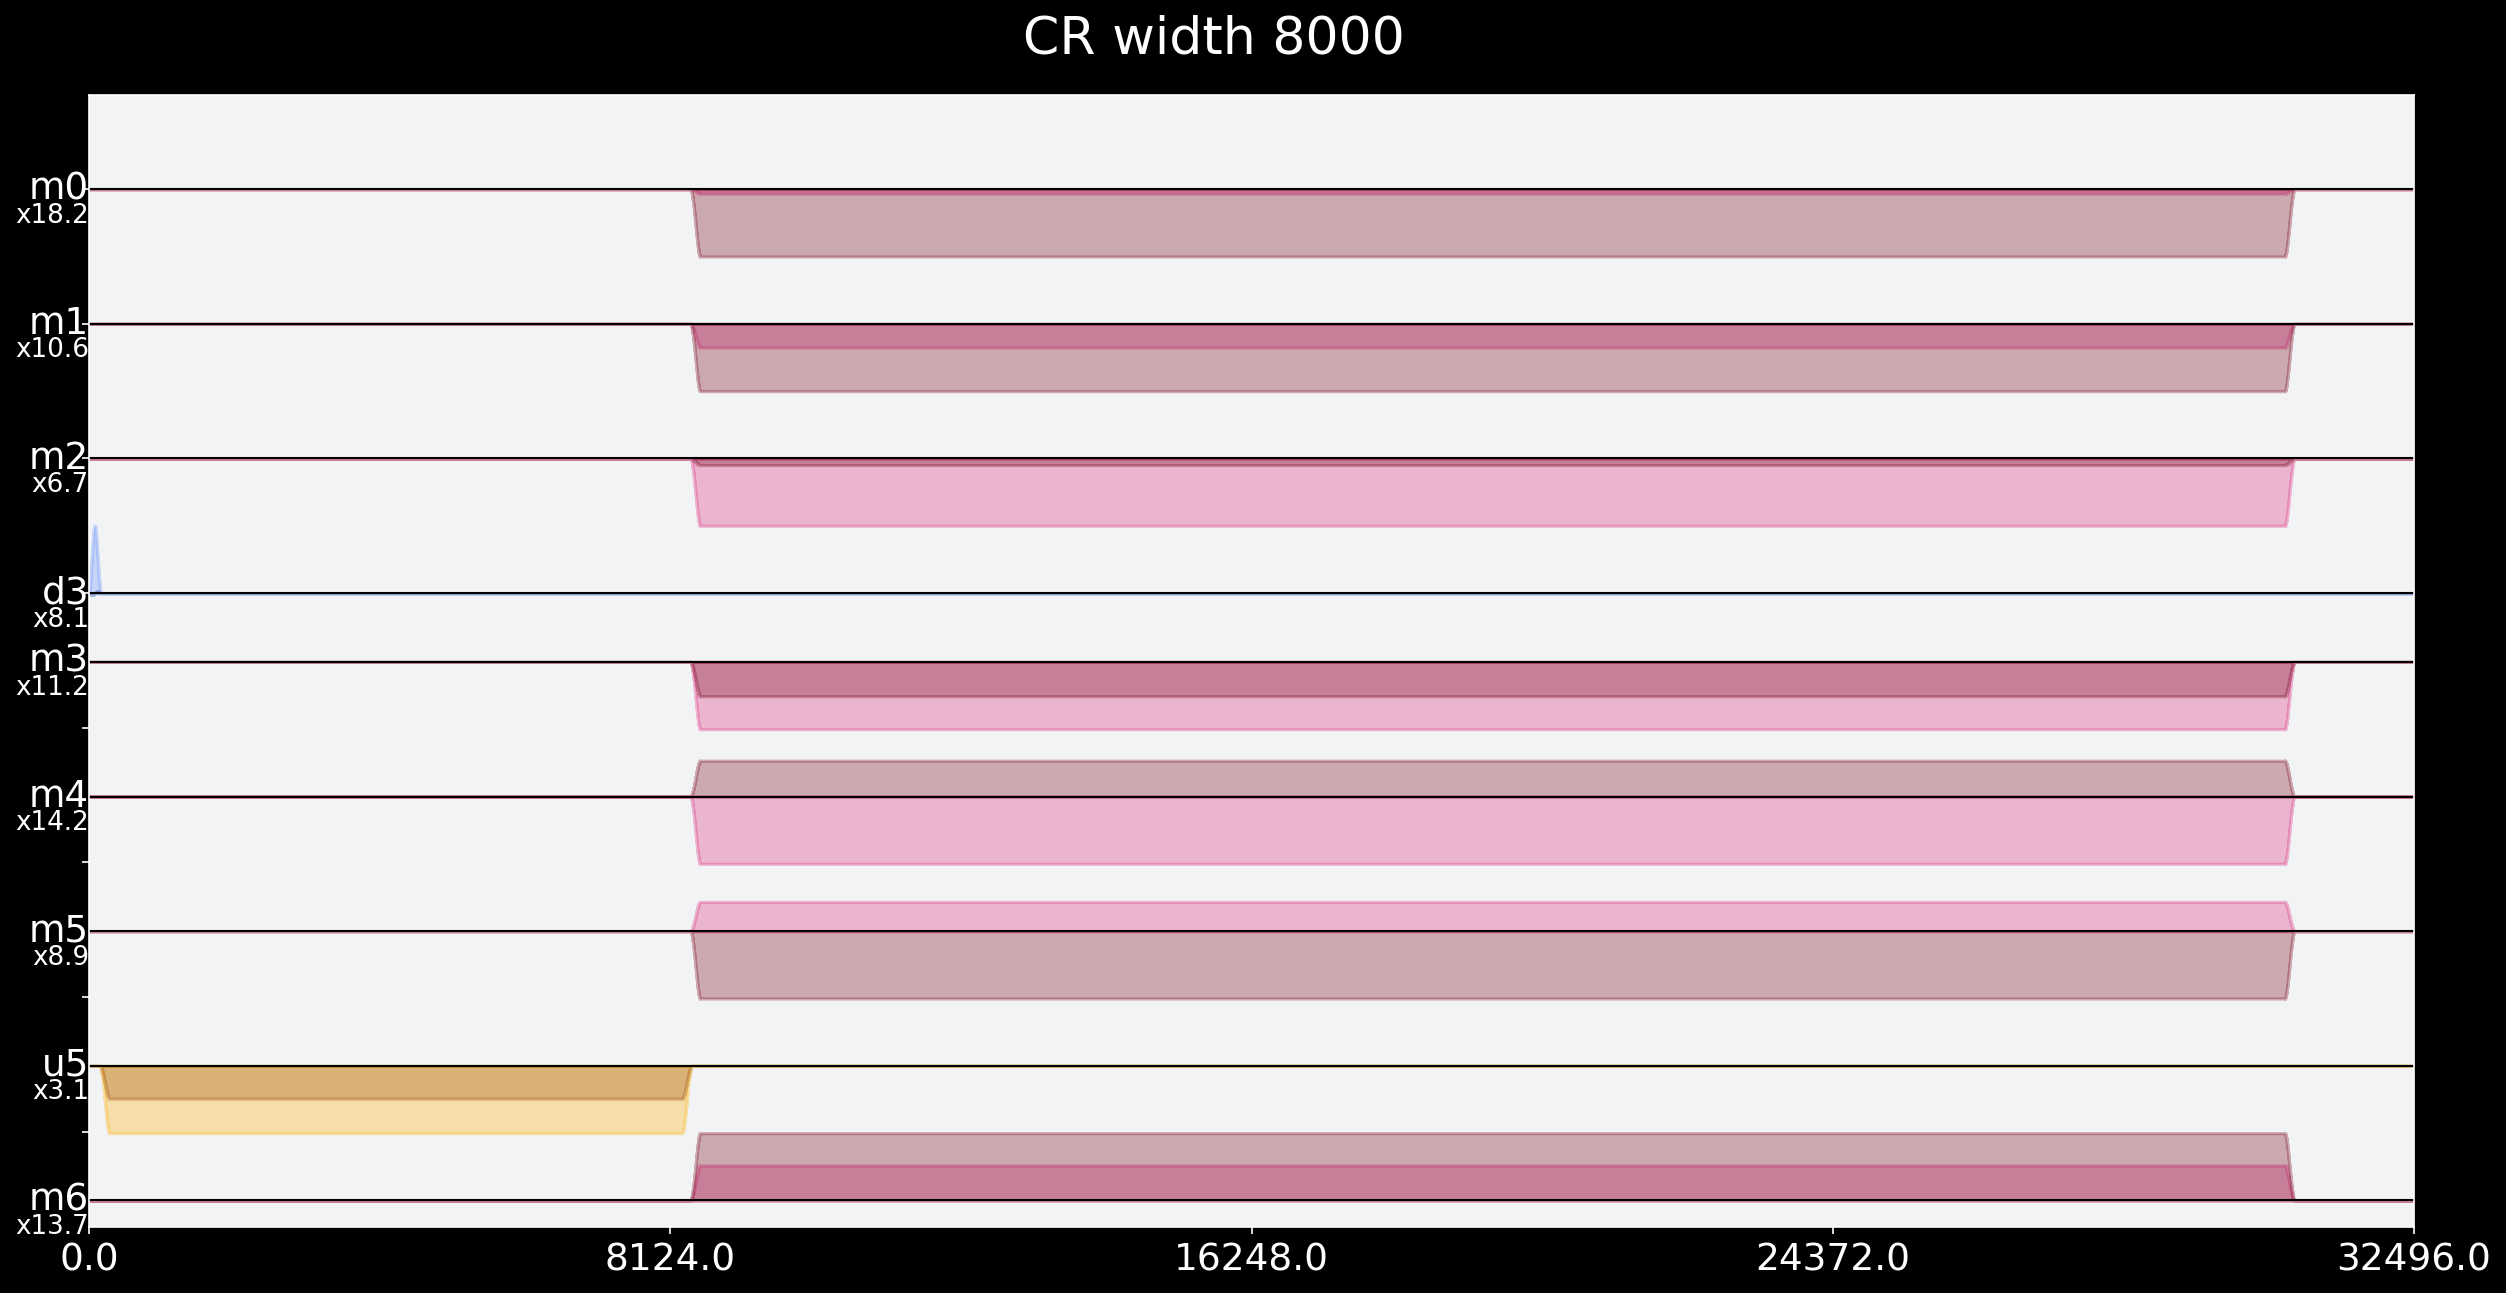

In [28]:
# remember samples must be in multiples of 16
cr_times = 16*np.linspace(0, 500, 21)
cr_scheds = build_cr_scheds(qc, qt, cr_times)
cr_scheds[-1].exclude(channels=[pulse.AcquireChannel(i) 
                        for i in range(backend_config.n_qubits)]).draw(style=style)

Note how the final schedule consists of the control in the $|1\rangle$ state due to the $\pi$-pulse on `d1` channel before the cross resonance pulse and this is measured in the $Z$-basis because there is no subsequent pulse on the `d0` channel.

## Run Experiment on Backend <a class="anchor" id="run-experiment-model"></a>

We will construct a [Duffing oscillator](https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html#4.-The-Quantized-Transmon-) model based on the Hamiltonian model. Then we collect the relevant Hamiltonian parameters from the `params` extracted from the backend configuration and create the model from them. 

In [29]:
from qiskit.providers.aer.pulse import duffing_system_model

dim_oscillators = 3 # cutoff Hilbert space dimension per transmon

SF = 1/(2*np.pi) # scale factor to convert from angular frequency to Hz

oscillator_freqs = [] # qubit transition frequencies
anharm_freqs = [] # qubit anharmonicities
drive_strengths = [] # drive Rabi strength
coupling_dict = {} # coupling strength between qubit pairs

for key in ham_params:
    if 'wq' in key:
        oscillator_freqs.append(ham_params[key]*SF)
    elif 'delta' in key:
        anharm_freqs.append(ham_params[key]*SF)
    elif 'omegad' in key:
        drive_strengths.append(ham_params[key]*SF)
    elif 'jq' in key:
        _, q0str, q1str = key.split('q')
        q0idx = int(q0str)
        q1idx = int(q1str)
        coupling_dict[(q0idx, q1idx)] = ham_params[key]*SF
        
# create the model
backend_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

In [30]:
from qiskit import assemble
from qiskit.providers.aer import PulseSimulator

#backend_sim = PulseSimulator()
backend_sim = backend #setting backend_sim to backend
qubit_lo_freq = backend_model.hamiltonian.get_qubit_lo_from_drift()

In [31]:
def assemblefunc(sched): 
    test_qobj = assemble(sched,backend=backend,qubit_lo_freq=qubit_lo_freq,meas_level=1,meas_return='avg', shots=5012)
    return test_qobj

In [32]:
test_objects = [assemblefunc(sched) for sched in cr_scheds]

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [33]:
# Experiment E1 

re_run = False

if re_run == True:
    jobiddict_c1t3_E1a = dict.fromkeys([x for x in range(len(test_objects))])
    for inum in range(len(test_objects)):
        to = test_objects[inum]
        job = backend.run(to)
        jobid = job.job_id()
        jobdict_t3[inum]=jobid 
    path = datadir + "CR_c1t3_E1_a.json"
    with open(path, 'w') as fp:
                json.dump(jobiddict_c1t3_E1a, fp,default=str)
else:
    print("re_run is set to False")

re_run is set to False


In [34]:
# load jobids for E1 control1 target3

path = datadir + "CR_c1t3_E1_a.json"
with open(path, 'r') as fp:
    jobiddict_c1t3_E1a =json.load(fp)
    
jobids = jobiddict_c1t3_E1a.values()
jobids = [x for x in jobids]

[backend.retrieve_job(jobid).status() for jobid in jobids]

[<JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.

# Status 2021-03-30: Waitig for results from E1 for control1 + target3

In [ ]:
# get results for E1

avg_t_c = np.zeros((6, len(cr_times)), dtype=complex)
avg_c_c = np.zeros((6, len(cr_times)), dtype=complex)

for jobid in jobids:
    job = backend.retrieve_job(jobid)
    result = job.result()
    result = result.get_memory(0)
    avg_t_c[key % 6, key // 6] = 1 - 2*result[qt]
    avg_c_c[key % 6, key // 6] = result[qc]

avg_t_c, avg_c_c = np.real(avg_t_c), np.real(avg_c_c)
print(avg_t_c, avg_c_c)

## Fitting the Results <a class="anchor" id="fitting-the-simulated-results"></a>

Using the `scipy` package, the fitting functions below will fit the Hamiltonian tomography data, Pauli expectations of the target qubit $\langle X(t) \rangle, \langle Y(t) \rangle, \langle Z(t) \rangle$, for the control prepared in either the ground or excited state. Note that we must use a trick to concatenate all the data into a single array by `tile`ing the time array and `vstack`ing the data so we can use the `curve_fit` function.

In [ ]:
from scipy.optimize import curve_fit

def get_omega(eDelta, eOmega_x, eOmega_y):
    """Return \Omega from parameter arguments."""
    eOmega = np.sqrt(eDelta**2 + eOmega_x**2 + eOmega_y**2)
    return eOmega

def avg_X(t, eDelta, eOmega_x, eOmega_y):
    """Return average X Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eXt = (-eDelta*eOmega_x + eDelta*eOmega_x*np.cos(eOmega*t) + \
           eOmega*eOmega_y*np.sin(eOmega*t)) / eOmega**2
    return eXt

def avg_Y(t, eDelta, eOmega_x, eOmega_y):
    """Return average Y Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eYt = (eDelta*eOmega_y - eDelta*eOmega_y*np.cos(eOmega*t) - \
           eOmega*eOmega_x*np.sin(eOmega*t)) / eOmega**2
    return eYt

def avg_Z(t, eDelta, eOmega_x, eOmega_y):
    """Return average Z Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eZt = (eDelta**2 + (eOmega_x**2 + eOmega_y**2)*np.cos(eOmega*t)) / eOmega**2
    return eZt

def rt_evol(ts, eDelta, eOmega_x, eOmega_y):
    """Stack average X,Y,Z Pauli measurements vertically."""
    return np.vstack([avg_X(ts, eDelta, eOmega_x, eOmega_y), \
                     avg_Y(ts, eDelta, eOmega_x, eOmega_y), \
                     avg_Z(ts, eDelta, eOmega_x, eOmega_y)])
    
def rt_flat(ts, eDelta, eOmega_x, eOmega_y):
    """Flatten X,Y,Z Pauli measurement data into 1D array."""
    return rt_evol(ts[0:len(ts)//3], eDelta, eOmega_x, eOmega_y).flatten()

def fit_rt_evol(ts, eXt, eYt, eZt, p0):
    """Use curve_fit to determine fit parameters of X,Y,Z Pauli measurements together."""
    rt_vec = np.asarray([eXt, eYt, eZt])
    return curve_fit(rt_flat, np.tile(ts, 3), rt_vec.flatten(), p0=p0)

In [ ]:
def get_interation_rates_MHz(ground_fit, excited_fit):
    """Determine interaction rates from fits to ground and excited control qubit data."""
    Delta0 = (ground_fit[0]/dt)/1e6
    Omega0_x = (ground_fit[1]/dt)/1e6
    Omega0_y = (ground_fit[2]/dt)/1e6
    Delta1 = (excited_fit[0]/dt)/1e6
    Omega1_x = (excited_fit[1]/dt)/1e6
    Omega1_y = (excited_fit[2]/dt)/1e6
    
    IX = 0.5*(Omega0_x + Omega1_x)
    IY = 0.5*(Omega0_y + Omega1_y)
    IZ = 0.5*(Delta0 + Delta1)
    ZX = 0.5*(Omega0_x - Omega1_x)
    ZY = 0.5*(Omega0_y - Omega1_y)
    ZZ = 0.5*(Delta0 - Delta1)
    
    return [[IX, IY, IZ], [ZX, ZY, ZZ]]

def plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit):
    """Plot Hamiltonian tomography data and curve fits with interaction rates."""
    coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
    ax1.scatter(cr_times, avg_t_c[0,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax1.plot(cr_times, avg_X(cr_times, *ground_fit), lw=3.0, color='blue')
    ax1.scatter(cr_times, avg_t_c[1,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax1.plot(cr_times, avg_X(cr_times, *excited_fit), lw=3.0, color='red')
    ax1.set_ylabel('<X(t)>', fontsize=20)
    ax1.set_title('Pauli Expectation Value', fontsize=20)
    ax1.legend(loc=4, fontsize=14)
    ax2.scatter(cr_times, avg_t_c[2,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax2.plot(cr_times, avg_Y(cr_times, *ground_fit), lw=3.0, color='blue')
    ax2.scatter(cr_times, avg_t_c[3,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax2.plot(cr_times, avg_Y(cr_times, *excited_fit), lw=3.0, color='red')
    ax2.set_title('IX = %.3f MHz   IY = %.3f MHz   IZ = %.3f MHz' % \
              (coeffs[0][0], coeffs[0][1], coeffs[0][2]), fontsize=20)
    ax2.set_ylabel('<Y(t)>', fontsize=20)
    ax2.legend(loc=4, fontsize=14)
    ax3.scatter(cr_times, avg_t_c[4,:].real, lw=3.0, color='blue', label='ctrl in |0>')
    ax3.plot(cr_times, avg_Z(cr_times, *ground_fit), lw=3.0, color='blue')
    ax3.scatter(cr_times, avg_t_c[5,:].real, lw=3.0, color='red', label='ctrl in |1>')
    ax3.plot(cr_times, avg_Z(cr_times, *excited_fit), lw=3.0, color='red')
    ax3.set_title('ZX = %.3f MHz   ZY = %.3f MHz   ZZ = %.3f MHz' % \
              (coeffs[1][0], coeffs[1][1], coeffs[1][2]), fontsize=20)
    ax3.set_ylabel('<Z(t)>', fontsize=20)
    ax3.set_xlabel('time (dt)', fontsize=20)
    ax3.legend(loc=4, fontsize=14)

### Fit and Plot

In [ ]:
ground_fit,_ = fit_rt_evol(cr_times, avg_t_c[0,:], avg_t_c[2,:], avg_t_c[4,:], p0=[0.0002, 0.0002, 0.0005])
excited_fit,_ = fit_rt_evol(cr_times, avg_t_c[1,:], avg_t_c[3,:], avg_t_c[5,:], p0=[0.0002, 0.001, 0.001])

plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit)

coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
ZX_rate = coeffs[1][0]
ZY_rate = coeffs[1][1]
phase = -np.arctan2(ZY_rate, ZX_rate)
print('Phase from ZY/ZX ratio is '+str(phase))

print("coeffs =\n", coeffs)
print("ZX_rate =",ZX_rate)
print("ZY_rate =",ZY_rate)
print("phase =",phase)

Note here that the magnitude of the $ZY$ interaction is a lot larger than the desired $ZX$ interaction. This is because the cross resonance pulse is out of phase with the single-qubit drive $IX$ on the target qubit (not the $IX$ here induced by the cross resonance pulse). We can determine this from the interaction rates and shift the phase of the cross resonance pulse in the next Hamiltonian tomography experiment.

In [ ]:
coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
ZX_rate = coeffs[1][0]
ZY_rate = coeffs[1][1]
phase = -np.arctan2(ZY_rate, ZX_rate)
print('Phase from ZY/ZX ratio is '+str(phase))

print("coeffs =\n", coeffs)
print("ZX_rate =",ZX_rate)
print("ZY_rate =",ZY_rate)
print("phase =",phase)

In [ ]:
# results from E1 for control 1, target 3



In [ ]:
def run_pulse(sched): 
    """Runs the scheduled experiment on the simulated backend.
    
    Args:
      sched: pulse schedule to run
    """
    # assemble the qobj
    test_qobj = assemble(sched,
                        backend=backend,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=5012)
    
    # run simulation
    pulseresult = backend.run(test_qobj).result()
    print(pulseresult.job_id())
    return pulseresult.get_memory(0)

def run_ham_tomo(cr_times, cr_scheds):
    """Run Hamiltonian tomography experiment and return results.
    
    Args:
      cr_times: widths of cross resonance pulses
      cr_scheds: array of pulse schedules for Ham Tomo experiment
    """
    # expectation values of target conditioned on control
    avg_t_c = np.zeros((6, len(cr_times)), dtype=complex)

    # sanity check: expectation values of control conditioned on control
    avg_c_c = np.zeros((6, len(cr_times)), dtype=complex)

    for ii in range(len(cr_scheds)):
        #if ii % 6 == 0:
        #    print(str(int(ii//6))+': Performing simulations for CR tone width of '+str(int(cr_times[ii//6]*dt*1e9))+' ns!')
        result = run_pulse(cr_scheds[ii])
        avg_t_c[ii % 6, ii // 6] = 1 - 2*result[qt]
        avg_c_c[ii % 6, ii // 6] = result[qc]
        
    return np.real(avg_t_c), np.real(avg_c_c)

In [ ]:
def run_circs_job_on_real_c(circs):
    backend = provider.get_backend('ibmq_casablanca')
    back_defaults = backend.defaults()
    inst_map = back_defaults.instruction_schedule_map
    transpiled_circs, scheds = [], []
    for circ in circs:
        tc = transpile(circ, backend, optimization_level=1)
        transpiled_circs.append(tc)
        sd = schedule(tc, backend, inst_map=inst_map)
        scheds.append(sd)
    print("number of schedules to run:",len(scheds))
    experiment = assemble(scheds,backend=backend,meas_level=1,meas_return='avg',shots=1000)
    jobids = []
    job = backend.run(experiment)
    jobid = job.job_id()
    print("jobid:",jobid)
    jobids.append(jobid)
    print("return list: jobids, transpiled_circs, scheds")
    return [jobids, transpiled_circs, scheds]

def retrieve_job_results(jobid_list):
    from qiskit.providers import JobStatus
    backend = provider.get_backend('ibmq_casablanca')
    results = []
    for jobid in jobid_list:
        job = backend.retrieve_job(jobid)
        if job.status() != JobStatus.DONE:
            print(job.status())
        else:
            res = job.result()
            results.append(res)
    return results

In [ ]:
def assemble_sched(sched):
    return assemble(sched, backend=backend,qubit_lo_freq=qubit_lo_freq, meas_level=1, meas_return='avg',shots=5012)

In [ ]:
cr_scheds_E2 = build_cr_scheds(qc, qt, cr_times, phase=phase_t1)

In [ ]:
jobids_E2_c1_t3 = []

re_run = True

if re_run == True:
    for inum in range(len(cr_scheds_E2)):
        crsched = cr_scheds_E2[inum]
        ash = assemble_sched(crsched)
        job = backend.run(ash)
        jobids_E2_c1_t3.append(job.job_id())
    path = datadir + 'jobids_E2_c1_t3.json'
    with open(path, 'w') as fp:
                json.dump(jobids_E2_c1_t3, fp,default=str)
            
else:
    print("re_run is set to False")

In [ ]:
path = datadir + 'jobids_E2_c1_t3.json'

with open(path, 'r') as fp:
    jobids_E2_c1_t3 = json.load(fp)

[backend.retrieve_job(jobid).status() for jobid in jobids_E2_c1_t3]

# Current status of work in progress: waiting for results from CR scheds

In [ ]:
# get results for E2 control 1, target 3 

jobdict = jobids_E2_c1_t3 

avg_t_c = np.zeros((6, len(cr_times)), dtype=complex)
avg_c_c = np.zeros((6, len(cr_times)), dtype=complex) 

for key in jobids_E2_c1_t3:
    job = backend.retrieve_job(jobid)
    result = job.result()
    result = result.get_memory(0)
    avg_t_c[key % 6, key // 6] = 1 - 2*result[qt]
    avg_c_c[key % 6, key // 6] = result[qc]

avg_t_c, avg_c_c = np.real(avg_t_c), np.real(avg_c_c)
print("avg_t_c=",avg_t_c, "\navg_c_c=",avg_c_c)

ground_fit,_ = fit_rt_evol(cr_times, avg_t_c[0,:], avg_t_c[2,:], avg_t_c[4,:], p0=[0.0002, 0.0002, 0.0005])
excited_fit,_ = fit_rt_evol(cr_times, avg_t_c[1,:], avg_t_c[3,:], avg_t_c[5,:], p0=[0.0002, 0.001, 0.001])

plot_cr_ham_tomo(cr_times, avg_t_c, avg_c_c, ground_fit, excited_fit)

Now we can see that the bulk of the cross resonance pulse provides the $ZX$-interaction that we can use to entangle qubits.

## Measure ZI (Stark Shift) via CR Ramsey Experiment <a class="anchor" id="measure-zi-via-ramsey"></a>

Here we measure the $ZI$ interaction term via a [Ramsey experiment](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#4.1-Measuring-the-qubit-Frequency-Precisely-using-a-Ramsey-Experiment-), recalling that the resulting oscillation are a result of the difference between the qubit and drive frequency. Since the frequency (Stark) shift and $ZI$ interaction are equivalent because a frequency shift induces a $Z$-rotation on the control qubit, we can measure this shift and compensate for it with a [frame change](https://arxiv.org/abs/1612.00858).

In [137]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt=backend_config.dt  # hardware resolution
backend.configuration().parametric_pulses = [] # will allow us to send a larger waveform for our experiments
style = SchedStyle(figsize=(3, 2), title_font_size=10, axis_font_size=8) # style for displaying the pulse sequence

In [138]:
from scipy.optimize import leastsq,minimize, curve_fit

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# Gaussian function
def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

#fit_gaussian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the gaussian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# normalize the data points to fall in the range of [0,1]
def normalize(a):
    a= a-min(a)
    return a/max(a)

In [115]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

qubit=3   # qubit used in our experiment

inst_sched_map = backend_defaults.instruction_schedule_map
# Get the default measurement pulse sequence
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])  

qubit_drive_sigma = 100e-9           #the width of the qubit spectroscopy drive
resonator_drive_sigma=10e-9          #the width of the resonator drive
drive_duration=10*qubit_drive_sigma  #the resonator drive duration

# We use a Gaussian shape pulse to drive the qubit for spectroscopy
qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .1,
                             sigma = get_closest_multiple_of_16(qubit_drive_sigma//dt),
                             name = 'qubit tone')


drive_chan = pulse.DriveChannel(qubit)   # qubit drive channel
meas_chan = pulse.MeasureChannel(qubit)  # resonator channel
acq_chan = pulse.AcquireChannel(qubit)   # readout signal acquisition channel

In [116]:
measurement_delay=20e-9

resonator_tone_amplitude = np.linspace(0,1,11) #change to amplitude
resonator_tone_pulses = []
for amp in resonator_tone_amplitude:
    # we use a square pulse with Gaussian rise and fall time to populate the resonator with photons
    temp_resonator_tone=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = amp,
                             sigma = get_closest_multiple_of_16(resonator_drive_sigma//dt),
                             width = get_closest_multiple_of_16((drive_duration-4*resonator_drive_sigma)//dt),
                             name = 'resonator tone')
    # pulse sequence for the experiment at different amplitudes
    with pulse.build(name=f"resonator tone amplitude = {np.round(amp,2)} V") as temp_pulse:
        pulse.play(qubit_drive, drive_chan)
        pulse.play(temp_resonator_tone, meas_chan)
        pulse.delay(int(measurement_delay//dt), meas_chan)
        pulse.call(measure)
    
    resonator_tone_pulses.append(temp_pulse)

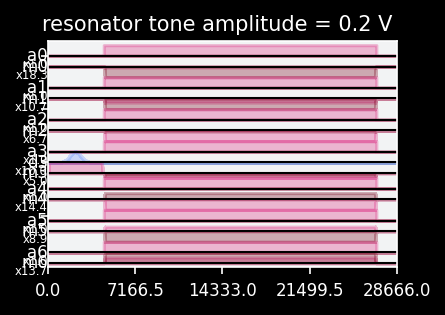

In [117]:
resonator_tone_pulses[2].draw(style=style)

In [118]:
start=4.960e9  # qubit spectroscopy start frequency
stop=4.980e9   # qubit spectroscopy stop frequency
freqs = np.linspace(start, stop, 41)-500e3
# list of qubit drive frequencies for spectroscopy
schedule_frequencies = [{drive_chan: freq , meas_chan: backend_defaults.meas_freq_est[qubit]} for freq in freqs]

In [120]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots = 4*1024

resonator_tone_experiments=[assemble(resonator_tone_pulses[i],
                            backend=backend, 
                            meas_level=1,
                            meas_return='avg',
                            shots=num_shots,
                            schedule_los= schedule_frequencies) for i in range(len(resonator_tone_pulses))]

In [122]:
re_run = True

if re_run == True:
    resonator_tone_results=[]
    jobids_E3_c1t3 = []
    for experiment in resonator_tone_experiments:
        job = backend.run(experiment)
        jobids_E3_c1t3.append(job.job_id())

        path = datadir + "jobids_E3_c1t3.json"
        with open(path, 'w') as fp:
                    json.dump(jobids_E3_c1t3, fp,default=str)
else:
    print('re_run is set to False')

In [113]:
path = datadir + "jobids_E3_c1t3.json"
with open(path, 'r') as fp:
    jobids_E3_c1t3 =json.load(fp)
    
[backend.retrieve_job(jobid).status() for jobid in jobids_E3_c1t3]

In [ ]:
import matplotlib.pyplot as plt

skip_idx=0

resonator_tone_results = [backend.retrieve_job(jobid).result() for jobid in jobids_E3_c1t3]

resonator_tone_values = []

for result in resonator_tone_results:
    result_values=[]
    for i in range(len(result.results)):
        result_values.append(result.get_memory(i)[qubit])
    resonator_tone_values.append(normalize(result_values))
    #resonator_tone_values.append(np.real(result_values))
    
plot_extent=[freqs[0]/1e9,freqs[-1]/1e9,resonator_tone_amplitude[skip_idx],resonator_tone_amplitude[-1]]
plt.imshow(np.abs(resonator_tone_values[skip_idx:]), aspect='auto', origin='lower', cmap='viridis',extent=plot_extent)
plt.xlabel('Qubit tone frequency [GHz]')
plt.ylabel('Resonator tone amplitude [V]')
plt.title('Qubit ac-Stark shift')
plt.show()

In [ ]:
show_individual_traces=False
skip_idx=3  # number of points to skip

center=[]
fwhm=[]
for i in range(len(resonator_tone_values)):
    popt,pcov=fit_gaussian(freqs,np.abs(np.real(resonator_tone_values[i])))
    center.append(popt[0])
    fwhm.append(2.355*popt[1])
    if show_individual_traces:
        plt.plot(freqs/1e3, np.real(resonator_tone_values[i]))
        plt.plot(freqs/1e3, gaussian(freqs,*popt), '--')
if show_individual_traces: plt.show()

center_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(center_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='grey')
plt.plot(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0])/1e6, 'o', color='black')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'$\delta \omega_q (MHz)$')
plt.show()

In [ ]:
fwhm_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(fwhm_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='orange')
plt.plot(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:])/1e6, 'o', color='red')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'FWHM (MHz)')
plt.show()